# 🧠 Motion Classification Pipeline

This notebook contains the complete pipeline to classify human motion states (FALL, MOTION, NO_MOTION) using wearable sensor data. It includes:

1. Converting raw sensor data to Label Studio format
2. Annotating time-series using Label Studio
3. Post-processing labeled data
4. Feature extraction & classification

Let's begin!


## 🧹 Step 1: Process Raw Sensor Data for Label Studio

We will clean and format the raw BHI360 sensor output into a JSON format compatible with [Label Studio](https://labelstud.io/).


In [17]:
import pandas as pd
import numpy as np
import csv
import sys
import json
import logging
import matplotlib.pyplot as plt
import os

from IPython.display import display
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from scipy.stats import kurtosis, skew
from scipy.fft import rfft
from scipy.signal import find_peaks


In [18]:
# CELL 2: Definitions from Block 2 (NoNaNJSONEncoder, csv_to_labelstudio_json)
class NoNaNJSONEncoder(json.JSONEncoder):
    """A custom JSON encoder that replaces NaN/Inf with None (i.e., null)."""
    def default(self, obj):
        if isinstance(obj, float):
            if np.isnan(obj) or np.isinf(obj):
                return None  # becomes 'null' in the final JSON
        return super().default(obj)

def csv_to_labelstudio_json(input_csv: str, output_json: str, skip_count: int = 4):
    """
    1) Reads the CSV (input_csv).
    2) Merges timestamps from:
       'sensortime_wakeup_ns' (unless '*') and
       'sensortime_nonwakeup_ns'.
    3) Renames sensor columns.
    4) Filters columns to keep only:
       {accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, timestamp_s}.
    5) Skips the first skip_count samples from each column.
    6) Builds the final JSON from remaining rows.
    7) Removes rows (in the final JSON) if any sensor column is '*'.
    8) Exports a single-task Label Studio–compatible JSON (output_json).
    """
    df = pd.read_csv(input_csv)

    df["timestamp_ns"] = df["sensortime_wakeup_ns"].mask(
        df["sensortime_wakeup_ns"] == "*",
        df["sensortime_nonwakeup_ns"]
    )
    df["timestamp_ns"] = pd.to_numeric(df["timestamp_ns"], errors="coerce")
    df["timestamp_s"] = df["timestamp_ns"] / 1e9

    rename_map = {
        "accelerometer_corrected_non_wakeup_ms2_x": "accel_x",
        "accelerometer_corrected_non_wakeup_ms2_y": "accel_y",
        "accelerometer_corrected_non_wakeup_ms2_z": "accel_z",
        "gyroscope_corrected_non_wakeup_dps_x": "gyro_x",
        "gyroscope_corrected_non_wakeup_dps_y": "gyro_y",
        "gyroscope_corrected_non_wakeup_dps_z": "gyro_z"
    }
    df.rename(columns=rename_map, inplace=True)

    columns_to_keep = [
        "accel_x", "accel_y", "accel_z",
        "gyro_x",  "gyro_y",  "gyro_z",
        "timestamp_s"
    ]
    df_filtered = df[columns_to_keep]
    df_skipped = df_filtered.iloc[skip_count:].reset_index(drop=True)

    sensor_cols = ["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"]
    valid_rows = []
    for _, row in df_skipped.iterrows():
        if any(str(row[col]) == '*' for col in sensor_cols):
            continue
        valid_rows.append(row)

    timeseries_dict = {col: [] for col in df_skipped.columns}
    for row in valid_rows:
        for col in df_skipped.columns:
            if col in sensor_cols:
                timeseries_dict[col].append(float(row[col]))
            else:
                timeseries_dict[col].append(row[col])

    tasks = [{"data": {"tsData": timeseries_dict}}]

    with open(output_json, "w") as f:
        json.dump(tasks, f, indent=2, cls=NoNaNJSONEncoder)

    display(f"Processed data (skipping first {skip_count} samples) saved to '{output_json}'.")


In [19]:
input_csv_path = "sensor_output/raw.csv"
output_json_path = "sensor_output/formatted.json"
skip_count = 0
csv_to_labelstudio_json(
    input_csv=input_csv_path,
     output_json=output_json_path,
     skip_count=skip_count
)

"Processed data (skipping first 0 samples) saved to 'sensor_output/formatted.json'."

## 🏷️ Step 2: Labeling in Label Studio

After generating the JSON file, load it into Label Studio using the following XML configuration. After labeling, make sure to export it as CSV.


### 📄 Label Studio XML Configuration

Use this config when creating the project in Label Studio:

```xml
<View>
  <TimeSeriesLabels name="tsLabels" toName="ts">
    <Label value="FALL" background="red"/>
    <Label value="MOTION" background="#ffea00"/>
    <Label value="NO_MOTION" background="#05ff16"/>
  </TimeSeriesLabels>

  <TimeSeries name="ts" valueType="json" value="$tsData" timeColumn="timestamp_s" ordered="true">
    <Channel column="accel_x" legend="accel_x"/>
    <Channel column="accel_y" legend="accel_y"/>
    <Channel column="accel_z" legend="accel_z"/>
    <Channel column="gyro_x" legend="gyro_x"/>
    <Channel column="gyro_y" legend="gyro_y"/>
    <Channel column="gyro_z" legend="gyro_z"/>
  </TimeSeries>
</View>


## 🧹 Step 3: Processing Labeled Data

In the following cells, we process the labeled data exported from LabelStudio. We first convert the raw time-series data into a CSV with 3 labels (MOTION, NO_MOTION, FALL) and then assign session IDs based on timestamp gaps. This processed data will later be used for feature extraction and model training.


In [20]:
def determine_label_3class(timestamp, intervals):
    """
    Prioritization: FALL > MOTION > NO_MOTION
    """
    if timestamp is None:
        return None

    for interval in intervals:
        start = interval.get("start")
        end = interval.get("end")
        ts_labels = interval.get("timeserieslabels", [])
        if start is not None and end is not None and start <= timestamp < end:
            labels_upper = [lbl.upper() for lbl in ts_labels]
            if "FALL" in labels_upper:
                return "FALL"
            elif "MOTION" in labels_upper:
                return "MOTION"
            elif "NO_MOTION" in labels_upper:
                return "NO_MOTION"
            else:
                return None
    return None

def convert_labelstudio_tsdata_with_3labels(input_csv, output_csv):
    """
    Simplified version for only 3 labels: MOTION, NO_MOTION, FALL.
    """
    csv.field_size_limit(sys.maxsize)
    all_rows = []

    with open(input_csv, 'r', newline='', encoding='utf-8') as f_in:
        reader = csv.DictReader(f_in)

        for row in reader:
            ts_str = row.get('tsData', '')
            if not ts_str:
                continue

            try:
                ts_dict = json.loads(ts_str)
            except json.JSONDecodeError as e:
                print(f"Warning: Could not parse tsData. Skipping. Error: {e}")
                continue

            intervals_str = row.get('tsLabels', '[]')
            try:
                intervals = json.loads(intervals_str)
            except json.JSONDecodeError as e:
                print(f"Warning: Could not parse tsLabels. Using empty intervals. Error: {e}")
                intervals = []

            sensor_keys = [
                "accel_x", "accel_y", "accel_z",
                "gyro_x", "gyro_y", "gyro_z",
                "timestamp_s"
            ]
            if any(k not in ts_dict for k in sensor_keys):
                continue

            length = len(ts_dict["timestamp_s"])
            for i in range(length):
                row_data = {}
                for k in sensor_keys:
                    arr = ts_dict[k]
                    row_data[k] = arr[i] if i < len(arr) else None

                label = determine_label_3class(row_data["timestamp_s"], intervals)
                if label is None:
                    continue

                sensor_values = [
                    row_data["accel_x"],
                    row_data["accel_y"],
                    row_data["accel_z"],
                    row_data["gyro_x"],
                    row_data["gyro_y"],
                    row_data["gyro_z"]
                ]
                if all(v is None for v in sensor_values):
                    continue

                row_data["label"] = label
                all_rows.append(row_data)

    out_cols = sensor_keys + ["label"]
    with open(output_csv, 'w', newline='', encoding='utf-8') as f_out:
        writer = csv.DictWriter(f_out, fieldnames=out_cols)
        writer.writeheader()
        writer.writerows(all_rows)


In [21]:
input_file = "labeled_data/raw.csv"
output_file = "labeled_data/formatted.csv"
convert_labelstudio_tsdata_with_3labels(input_file, output_file)
print(f"Done! Wrote 3-label CSV to '{output_file}'.")

Done! Wrote 3-label CSV to 'labeled_data/formatted.csv'.


In [22]:
def sort_by_timestamp(input_csv, output_csv):
    df = pd.read_csv(input_csv)
    df_sorted = df.sort_values(by='timestamp_s', ascending=True)
    df_sorted.to_csv(output_csv, index=False)
    print(f"Sorted data saved to '{output_csv}'.")


In [23]:
input_file = "labeled_data/formatted.csv"
output_file = "labeled_data/formatted_sorted.csv"
sort_by_timestamp(input_file, output_file)

Sorted data saved to 'labeled_data/formatted_sorted.csv'.


In [24]:
def find_top_timestamp_jumps(filename, top_n=10):
    df = pd.read_csv(filename)
    if 'timestamp_s' not in df.columns:
        print("Error: 'timestamp_s' column not found in the CSV.")
        return

    df['timestamp_diff'] = df['timestamp_s'].diff()
    top_jumps = df['timestamp_diff'].nlargest(top_n)

    print(f"Top {top_n} largest timestamp jumps:\n")
    for idx, jump in top_jumps.items():
        print(f"Jump #{top_jumps.index.get_loc(idx)+1}")
        print(f"Index: {idx}")
        print(f"Time before jump: {df.loc[idx - 1, 'timestamp_s']}")
        print(f"Time after jump:  {df.loc[idx, 'timestamp_s']}")
        print(f"Jump size:        {jump}")
        print("-" * 40)


In [25]:
def main_find_top_jumps():
     filename = "labeled_data/formatted_sorted.csv"
     find_top_timestamp_jumps(filename)
 
main_find_top_jumps()

Top 10 largest timestamp jumps:

Jump #1
Index: 382109
Time before jump: 2215.907984375
Time after jump:  2438.601921875
Jump size:        222.69393749999972
----------------------------------------
Jump #2
Index: 24490
Time before jump: 265.187953125
Time after jump:  434.292140625
Jump size:        169.10418750000002
----------------------------------------
Jump #3
Index: 202867
Time before jump: 1026.67615625
Time after jump:  1183.543609375
Jump size:        156.86745312499988
----------------------------------------
Jump #4
Index: 294509
Time before jump: 1485.751671875
Time after jump:  1641.736046875
Jump size:        155.984375
----------------------------------------
Jump #5
Index: 61153
Time before jump: 528.77203125
Time after jump:  657.9365
Jump size:        129.16446874999997
----------------------------------------
Jump #6
Index: 356402
Time before jump: 1960.441296875
Time after jump:  2034.097609375
Jump size:        73.65631250000001
----------------------------------

In [26]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def assign_sessions(input_file, output_file, threshold=10.0):
    logging.info(f"Reading input file: {input_file}")
    df = pd.read_csv(input_file)

    logging.info("Calculating timestamp differences...")
    df['timestamp_diff'] = df['timestamp_s'].diff().fillna(0)

    logging.info(f"Detecting new sessions with timestamp jumps > {threshold}s")
    df['session_id'] = (df['timestamp_diff'] > threshold).cumsum() + 1  # start at 1

    total_sessions = df['session_id'].nunique()
    logging.info(f"✅ Total sessions detected: {total_sessions}")

    for session_id in sorted(df['session_id'].unique()):
        session_data = df[df['session_id'] == session_id]
        total_rows = len(session_data)
        label_counts = session_data['label'].value_counts().to_dict()
        motion = label_counts.get("MOTION", 0)
        fall = label_counts.get("FALL", 0)
        no_motion = label_counts.get("NO_MOTION", 0)
        logging.info(
            f"Session {session_id:>2}: {total_rows} rows | "
            f"MOTION: {motion}, FALL: {fall}, NO_MOTION: {no_motion}"
        )

    df.drop(columns=['timestamp_diff'], inplace=True)
    df.to_csv(output_file, index=False)
    logging.info(f"Output saved to {output_file}")


In [27]:
assign_sessions("labeled_data/formatted_sorted.csv", "labeled_data/formatted_sorted_id.csv", threshold=10)

2025-04-05 19:06:55,322 - INFO - Reading input file: labeled_data/formatted_sorted.csv
2025-04-05 19:06:55,497 - INFO - Calculating timestamp differences...
2025-04-05 19:06:55,500 - INFO - Detecting new sessions with timestamp jumps > 10s
2025-04-05 19:06:55,507 - INFO - ✅ Total sessions detected: 10
2025-04-05 19:06:55,514 - INFO - Session  1: 24490 rows | MOTION: 6569, FALL: 0, NO_MOTION: 17921
2025-04-05 19:06:55,518 - INFO - Session  2: 36663 rows | MOTION: 14223, FALL: 0, NO_MOTION: 22440
2025-04-05 19:06:55,525 - INFO - Session  3: 81523 rows | MOTION: 59678, FALL: 1652, NO_MOTION: 20193
2025-04-05 19:06:55,532 - INFO - Session  4: 60191 rows | MOTION: 20133, FALL: 0, NO_MOTION: 40058
2025-04-05 19:06:55,538 - INFO - Session  5: 60959 rows | MOTION: 41143, FALL: 4775, NO_MOTION: 15041
2025-04-05 19:06:55,541 - INFO - Session  6: 30683 rows | MOTION: 25158, FALL: 3402, NO_MOTION: 2123
2025-04-05 19:06:55,546 - INFO - Session  7: 31352 rows | MOTION: 13074, FALL: 3371, NO_MOTION: 

## 🤖 Step 4: Feature Extraction and Model Training

We now extract statistical features from each window of time-series data and train a machine learning classifier.

Approach:
- Extract statistical/time/frequency-domain features
- Use SMOTE to handle class imbalance
- Use HistGradientBoostingClassifier
- Evaluate using Leave-One-Session-Out cross-validation

In [28]:
def read_data(csv_path):
    df = pd.read_csv(csv_path)
    df = df.sort_values(by=["session_id", "timestamp_s"]).reset_index(drop=True)
    return df

In [29]:
def compute_additional_features(vals, prefix="acc_x_"):
    if len(vals) == 0:
        return {
            f"{prefix}energy": np.nan,
            f"{prefix}zcr": np.nan,
            f"{prefix}iqr": np.nan
        }
    energy = np.sum(np.square(vals))
    zcr = (np.sum(np.diff(np.sign(vals)) != 0) / (len(vals) - 1)
           if len(vals) > 1 else np.nan)
    iqr = np.percentile(vals, 75) - np.percentile(vals, 25)
    return {
        f"{prefix}energy": energy,
        f"{prefix}zcr": zcr,
        f"{prefix}iqr": iqr
    }

In [30]:
def extract_advanced_features_from_timeseries(df_timeseries, window_size=2, step_size=0.25, do_fft=True):
    df = df_timeseries.copy()
    df["timestamp_s"] = df["timestamp_s"].astype(float)

    def safe_corr(a, b):
        return np.corrcoef(a, b)[0, 1] if len(a) > 1 else np.nan

    def compute_time_stats(vals, prefix="acc_x_"):
        if len(vals) == 0:
            return {
                f"{prefix}{stat}": np.nan
                for stat in [
                    "mean", "var", "skew", "kurt", "median",
                    "range", "rms", "p10", "p25", "p50", "p75"
                ]
            }
        return {
            f"{prefix}mean": np.mean(vals),
            f"{prefix}var": np.var(vals),
            f"{prefix}skew": skew(vals),
            f"{prefix}kurt": kurtosis(vals),
            f"{prefix}median": np.median(vals),
            f"{prefix}range": np.max(vals) - np.min(vals),
            f"{prefix}rms": np.sqrt(np.mean(vals**2)),
            f"{prefix}p10": np.percentile(vals, 10),
            f"{prefix}p25": np.percentile(vals, 25),
            f"{prefix}p50": np.percentile(vals, 50),
            f"{prefix}p75": np.percentile(vals, 75)
        }

    def compute_fft_stats(vals, prefix="acc_x_"):
        if len(vals) < 2:
            return {
                f"{prefix}fft_sum_amp": np.nan,
                f"{prefix}fft_peak_idx": np.nan
            }
        fft_vals = rfft(vals)
        mag = np.abs(fft_vals)
        return {
            f"{prefix}fft_sum_amp": np.sum(mag),
            f"{prefix}fft_peak_idx": np.argmax(mag)
        }

    all_windows = []
    for session_id in df["session_id"].unique():
        df_session = df[df["session_id"] == session_id]
        start_time = df_session["timestamp_s"].min()
        end_time = df_session["timestamp_s"].max()
        current_start = start_time

        while current_start <= end_time:
            current_end = current_start + window_size
            mask = (df_session["timestamp_s"] >= current_start) & (df_session["timestamp_s"] < current_end)
            df_w = df_session[mask]
            if len(df_w) > 0:
                ax, ay, az = df_w["accel_x"].values, df_w["accel_y"].values, df_w["accel_z"].values
                gx, gy, gz = df_w["gyro_x"].values, df_w["gyro_y"].values, df_w["gyro_z"].values
                acc_mag = np.sqrt(ax**2 + ay**2 + az**2)
                gyro_mag = np.sqrt(gx**2 + gy**2 + gz**2)

                stats = {}
                for prefix, vals in zip(
                    ["acc_x_", "acc_y_", "acc_z_", "gyro_x_", "gyro_y_", "gyro_z_"],
                    [ax, ay, az, gx, gy, gz]
                ):
                    stats.update(compute_time_stats(vals, prefix))
                    if do_fft:
                        stats.update(compute_fft_stats(vals, prefix))
                    stats.update(compute_additional_features(vals, prefix))

                stats.update(compute_time_stats(acc_mag, prefix="acc_mag_"))
                if do_fft:
                    stats.update(compute_fft_stats(acc_mag, prefix="acc_mag_"))
                stats.update(compute_additional_features(acc_mag, prefix="acc_mag_"))

                stats.update(compute_time_stats(gyro_mag, prefix="gyro_mag_"))
                if do_fft:
                    stats.update(compute_fft_stats(gyro_mag, prefix="gyro_mag_"))
                stats.update(compute_additional_features(gyro_mag, prefix="gyro_mag_"))

                stats.update({
                    "acc_xy_corr": safe_corr(ax, ay),
                    "acc_xz_corr": safe_corr(ax, az),
                    "acc_yz_corr": safe_corr(ay, az),
                    "gyro_xy_corr": safe_corr(gx, gy),
                    "gyro_xz_corr": safe_corr(gx, gz),
                    "gyro_yz_corr": safe_corr(gy, gz)
                })

                if len(acc_mag) > 0:
                    peak_idx = np.argmax(acc_mag)
                    peak_val = acc_mag[peak_idx]
                    time_to_peak = df_w["timestamp_s"].iloc[peak_idx] - current_start
                    median_val = np.median(acc_mag)
                    stats.update({
                        "acc_impact_peak_val": peak_val,
                        "acc_impact_time_to_peak": time_to_peak,
                        "acc_impact_median_diff": peak_val - median_val
                    })
                else:
                    stats["acc_impact_peak_val"] = np.nan
                    stats["acc_impact_time_to_peak"] = np.nan
                    stats["acc_impact_median_diff"] = np.nan

                jerk_x = np.diff(ax, prepend=ax[0])
                jerk_y = np.diff(ay, prepend=ay[0])
                jerk_z = np.diff(az, prepend=az[0])
                jerk_mag = np.sqrt(jerk_x**2 + jerk_y**2 + jerk_z**2)
                stats.update(compute_time_stats(jerk_mag, prefix="jerk_mag_"))
                stats.update(compute_additional_features(jerk_mag, prefix="jerk_mag_"))

                sma = np.sum(np.abs(ax) + np.abs(ay) + np.abs(az)) / len(ax)
                stats["sma"] = sma

                g = 9.81
                tilt_angle = np.clip(az / g, -1.0, 1.0)
                tilt_angle = np.arccos(tilt_angle)
                stats["tilt_angle_mean"] = np.mean(tilt_angle)
                stats["tilt_angle_std"] = np.std(tilt_angle)

                peaks, _ = find_peaks(acc_mag, height=np.mean(acc_mag) + np.std(acc_mag))
                stats["acc_num_peaks"] = len(peaks)

                label = df_w["label"].value_counts().idxmax()
                stats.update({
                    "start_time": current_start,
                    "end_time": current_end,
                    "label": label,
                    "session_id": session_id
                })
                all_windows.append(stats)
            current_start += step_size

    df_feat = pd.DataFrame(all_windows)
    df_feat.dropna(subset=["label"], inplace=True)
    return df_feat


In [31]:
csv_path = "labeled_data/formatted_sorted_id.csv"
df_raw = read_data(csv_path)
df_features = extract_advanced_features_from_timeseries(df_raw, window_size=2, step_size=0.25, do_fft=True)
print(f"Extracted {len(df_features)} windows.")


Extracted 5256 windows.


In [33]:
from sklearn.ensemble import HistGradientBoostingClassifier

def augment_with_noise(X, y, noise_level=0.01, num_copies=2):
    X_list = [X]
    y_list = [y]
    std_dev = X.std(axis=0, keepdims=True)
    for _ in range(num_copies):
        noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
        X_list.append(X + noise * std_dev)
        y_list.append(y)
    return np.concatenate(X_list, axis=0), np.concatenate(y_list, axis=0)

def loso_cv_print_each(df_features, feat_cols, model_params):
    sessions = df_features["session_id"].unique()
    session_results = []
    le = LabelEncoder()
    all_labels = sorted(df_features["label"].unique())
    le.fit(all_labels)
    print("Encoded classes order:", le.classes_)
    
    for test_session in sessions:
        train_df = df_features[df_features["session_id"] != test_session]
        test_df = df_features[df_features["session_id"] == test_session]
        
        X_train = train_df[feat_cols].values
        y_train = train_df["label"].values
        X_test = test_df[feat_cols].values
        y_test = test_df["label"].values
        
        imp = SimpleImputer(strategy="mean")
        X_train_imp = imp.fit_transform(X_train)
        X_test_imp = imp.transform(X_test)
        
        X_aug, y_aug = augment_with_noise(X_train_imp, y_train, noise_level=0.01, num_copies=2)
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X_aug, y_aug)
        
        y_res_enc = le.transform(y_res)
        y_test_enc = le.transform(y_test)
        
        model = HistGradientBoostingClassifier(random_state=42, **model_params)
        class_weights = {0: 5.0, 1: 1.0, 2: 1.0}
        sample_weights = np.array([class_weights[label] for label in y_res_enc])
    
        model.fit(X_res, y_res_enc, sample_weight=sample_weights)
        y_pred_enc = model.predict(X_test_imp)
        
        report = classification_report(y_test_enc, y_pred_enc, output_dict=True, zero_division=0)
        macro_f1 = report["macro avg"]["f1-score"]
        cm = confusion_matrix(y_test_enc, y_pred_enc, labels=range(len(le.classes_)))
        session_results.append((test_session, macro_f1, cm))
        
        print(f"\nSession {test_session} Confusion Matrix:")
        print(cm)
    
    return session_results, le, all_labels


In [34]:
def plot_row_normalized_confusion_matrix(cm, labels, title=""):
    """
    Displays a row-normalized confusion matrix in a 'Blues' colormap.
    """
    n = cm.shape[0]
    normalized_cm = np.zeros_like(cm, dtype=float)
    for i in range(n):
        row_sum = np.sum(cm[i, :])
        normalized_cm[i, :] = cm[i, :] / row_sum if row_sum > 0 else 0

    fig, ax = plt.subplots(figsize=(8, 6))
    # Use the 'Blues' cmap to match the original color style
    im = ax.imshow(normalized_cm, cmap="Blues", vmin=0, vmax=1)

    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    
    for i in range(n):
        row_sum = np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 1
        for j in range(n):
            percentage = (cm[i, j] / row_sum * 100)
            ax.text(j, i, f"{cm[i, j]}\n({percentage:.1f}%)",
                    ha="center", va="center", color="black")
    
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


def print_combined_metrics(cm, labels):
    n = cm.shape[0]
    total = np.sum(cm)
    accuracy = np.trace(cm) / total if total > 0 else 0
    precisions, recalls, f1s = [], [], []
    print("\nMetrics per class:")
    for i in range(n):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        print(f"Class {labels[i]}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1s)
    print(f"\nOverall Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1: {macro_f1:.4f}")


In [37]:
# CELL 18: Definitions from Block 14 (main experiment)
def main():
    """
    Main function to run LOSO CV on the selected feature subset and 
    print overall results + combined confusion matrix.
    """
    # Example: we assume df_features is already created from previous steps
    selected_features = ['acc_mag_iqr', 'acc_x_range', 'acc_y_range']

    best_params = {'learning_rate': 0.01, 'max_iter': 200, 'max_leaf_nodes': 31}
    print(f"\nEvaluating selected feature combination: {selected_features}")
    session_results, le, labels = loso_cv_print_each(df_features, selected_features, best_params)
    
    combined_cm = np.zeros_like(session_results[0][2])
    for _, _, cm in session_results:
        combined_cm += cm
    
    print("\nCombined Confusion Matrix (All Sessions):")
    print(combined_cm)
    plot_row_normalized_confusion_matrix(combined_cm, labels, "Combined Confusion Matrix (Row-Normalized)")
    
    print_combined_metrics(combined_cm, labels)



Evaluating selected feature combination: ['acc_mag_iqr', 'acc_x_range', 'acc_y_range']
Encoded classes order: ['FALL' 'MOTION' 'NO_MOTION']

Session 1 Confusion Matrix:
[[  0   0   0]
 [  8  75  19]
 [  0   3 273]]

Session 2 Confusion Matrix:
[[  0   0   0]
 [  8 108  29]
 [  0   4 229]]

Session 3 Confusion Matrix:
[[  4   3   0]
 [ 69 376  73]
 [  7  22 132]]

Session 4 Confusion Matrix:
[[  0   0   0]
 [  8 144   4]
 [  2  71 313]]

Session 5 Confusion Matrix:
[[ 35  14   0]
 [ 40 281 104]
 [  4   4 145]]

Session 6 Confusion Matrix:
[[ 25   0   0]
 [ 59 209   0]
 [  0   8  14]]

Session 7 Confusion Matrix:
[[ 30   5   0]
 [ 27 107   0]
 [  4  39 110]]

Session 8 Confusion Matrix:
[[ 38  16   0]
 [ 31 144  13]
 [  7  79 359]]

Session 9 Confusion Matrix:
[[ 75  23   0]
 [ 23 194   1]
 [  2  27 383]]

Session 10 Confusion Matrix:
[[  0   0   0]
 [ 29 191  49]
 [  2  12 310]]

Combined Confusion Matrix (All Sessions):
[[ 207   61    0]
 [ 302 1829  292]
 [  28  269 2268]]


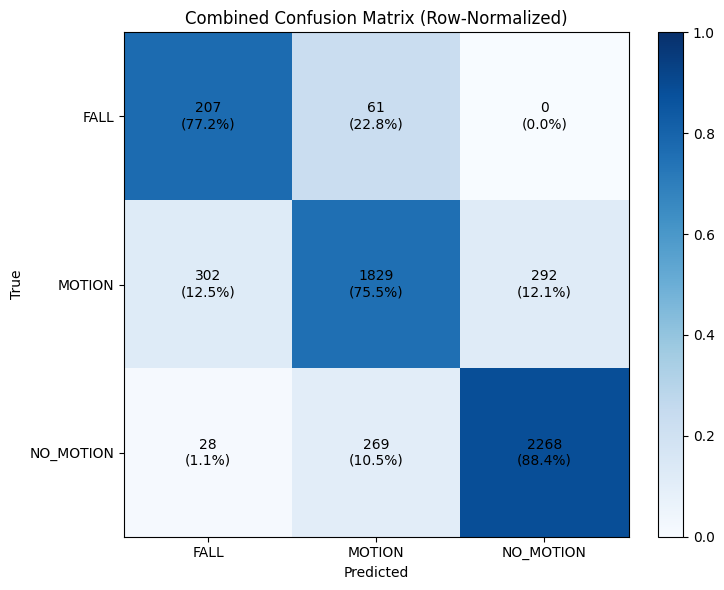


Metrics per class:
Class FALL: Precision: 0.3855, Recall: 0.7724, F1: 0.5143
Class MOTION: Precision: 0.8472, Recall: 0.7548, F1: 0.7983
Class NO_MOTION: Precision: 0.8859, Recall: 0.8842, F1: 0.8851

Overall Accuracy: 0.8189
Macro Precision: 0.7062, Macro Recall: 0.8038, Macro F1: 0.7326


In [38]:
df_raw = read_data("labeled_data/formatted_sorted_id.csv")
df_features = extract_advanced_features_from_timeseries(df_raw, window_size=2, step_size=0.25, do_fft=True)
main()


## 📊 Step 5: Conclusions & Reporting

- Evaluated model performance using Leave-One-Session-Out (LOSO) cross-validation.
- Visualized class-wise prediction accuracy using row-normalized confusion matrices.
- Computed and reported overall accuracy, macro precision, recall, and F1-score.
- Feature combination used: `acc_mag_iqr`, `acc_x_range`, `acc_y_range`


In [36]:
def main(num_runs=100):
    """
    Runs the LOSO CV pipeline multiple times and aggregates macro-F1 scores
    and confusion matrices over all runs.

    Reports:
    - Mean ± std of macro F1-score
    - Total combined confusion matrix across all runs
    - Final evaluation metrics on the aggregated matrix
    """
    selected_features = ['acc_mag_iqr', 'acc_x_range', 'acc_y_range']
    best_params = {'learning_rate': 0.01, 'max_iter': 200, 'max_leaf_nodes': 31}
    
    print(f"🔁 Running LOSO CV {num_runs} times...")
    print(f"📊 Feature subset: {selected_features}")

    all_macro_f1 = []
    cumulative_cm = None
    labels = []

    for run in range(1, num_runs + 1):
        print(f"\n⚙️ Run {run}/{num_runs}")
        session_results, le, labels = loso_cv_print_each(df_features, selected_features, best_params)

        # Combine confusion matrix for this run
        run_cm = np.zeros_like(session_results[0][2])
        for _, _, cm in session_results:
            run_cm += cm

        # Initialize cumulative_cm if first run
        if cumulative_cm is None:
            cumulative_cm = run_cm
        else:
            cumulative_cm += run_cm

        macro_f1 = np.mean([f1 for _, f1, _ in session_results])
        all_macro_f1.append(macro_f1)
        print(f"➡️  Macro F1 (Run {run}): {macro_f1:.4f}")

    # Final metrics
    avg_f1 = np.mean(all_macro_f1)
    std_f1 = np.std(all_macro_f1)

    print("\n📈 Final Results over", num_runs, "runs:")
    print(f"✅ Macro F1-score: {avg_f1:.4f} ± {std_f1:.4f}")

    print("\n🧩 Combined Confusion Matrix (Aggregated Over All Runs):")
    print(cumulative_cm)
    plot_row_normalized_confusion_matrix(cumulative_cm, labels, "Aggregated Confusion Matrix (All Runs)")
    print_combined_metrics(cumulative_cm, labels)


🔁 Running LOSO CV 100 times...
📊 Feature subset: ['acc_mag_iqr', 'acc_x_range', 'acc_y_range']

⚙️ Run 1/100
Encoded classes order: ['FALL' 'MOTION' 'NO_MOTION']

Session 1 Confusion Matrix:
[[  0   0   0]
 [ 12  71  19]
 [  0   2 274]]

Session 2 Confusion Matrix:
[[  0   0   0]
 [  6 109  30]
 [  0   6 227]]

Session 3 Confusion Matrix:
[[  3   4   0]
 [ 61 390  67]
 [  6  23 132]]

Session 4 Confusion Matrix:
[[  0   0   0]
 [  6 146   4]
 [  0  71 315]]

Session 5 Confusion Matrix:
[[ 35  14   0]
 [ 42 278 105]
 [  5   3 145]]

Session 6 Confusion Matrix:
[[ 25   0   0]
 [ 64 204   0]
 [  0   8  14]]

Session 7 Confusion Matrix:
[[ 30   5   0]
 [ 31 103   0]
 [  4  38 111]]

Session 8 Confusion Matrix:
[[ 46   8   0]
 [ 30 145  13]
 [  8  74 363]]

Session 9 Confusion Matrix:
[[ 75  23   0]
 [ 28 190   0]
 [  1  25 386]]

Session 10 Confusion Matrix:
[[  0   0   0]
 [ 27 195  47]
 [  3  11 310]]
➡️  Macro F1 (Run 1): 0.6552

⚙️ Run 2/100
Encoded classes order: ['FALL' 'MOTION' 'NO_

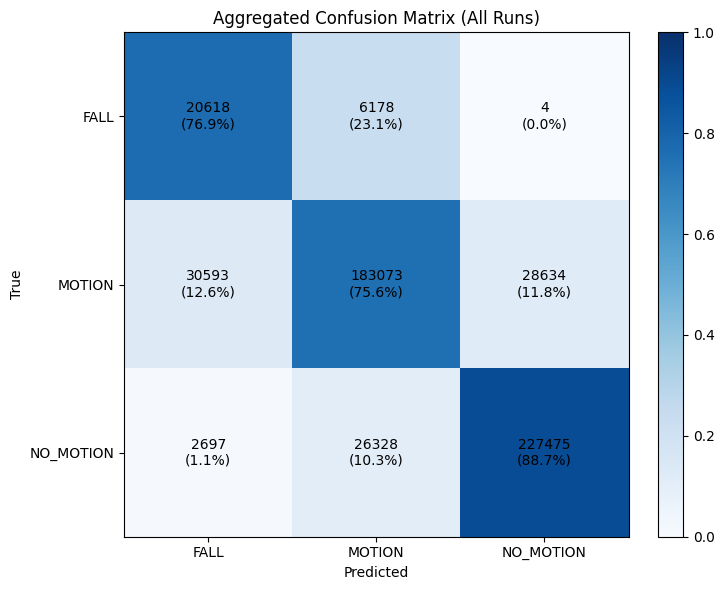


Metrics per class:
Class FALL: Precision: 0.3825, Recall: 0.7693, F1: 0.5109
Class MOTION: Precision: 0.8492, Recall: 0.7556, F1: 0.7997
Class NO_MOTION: Precision: 0.8882, Recall: 0.8868, F1: 0.8875

Overall Accuracy: 0.8203
Macro Precision: 0.7066, Macro Recall: 0.8039, Macro F1: 0.7327


In [37]:
df_raw = read_data("labeled_data/formatted_sorted_id.csv")
df_features = extract_advanced_features_from_timeseries(df_raw, window_size=2, step_size=0.25, do_fft=True)
main()
